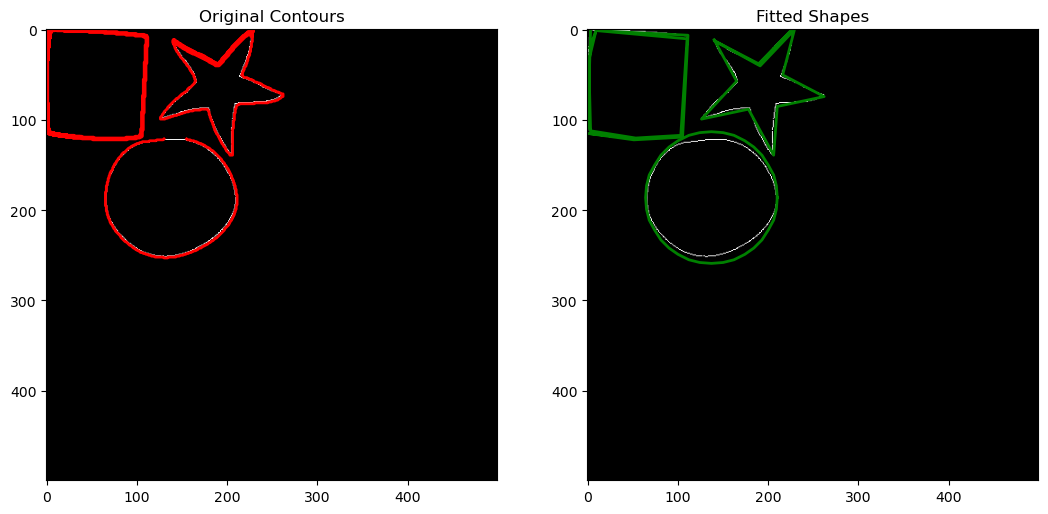

In [15]:
import cv2
import numpy as np
import svgwrite
import cairosvg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import filedialog, messagebox

# Colors for SVG paths
colours = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# 1. Reading CSV I/O for Shapes
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def write_csv(output_path, shapes):
    with open(output_path, 'w') as f:
        for i, shape in enumerate(shapes):
            if isinstance(shape, dict):
                if shape['type'] == 'circle':
                    f.write(f"{i},circle,{shape['center'][0]},{shape['center'][1]},{shape['radius']}\n")
                elif shape['type'] == 'ellipse':
                    f.write(f"{i},ellipse,{','.join(map(str, shape['params']))}\n")
            else:  # Assuming it's a numpy array of points
                for point in shape:
                    f.write(f"{i},{point[0]},{point[1]}\n")

# 2. Plot Points on Image
def plot_points_on_image(points, img_size=(500, 500)):
    image = np.zeros(img_size, dtype=np.uint8)
    for shape in points:
        for contour in shape:
            for point in contour:
                x, y = int(point[0]), int(point[1])
                image[y, x] = 255
    return image

# 3. Preprocessing Image
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    return edged

# 4. Find and Classify Contours
def find_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def classify_shape(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

    if len(approx) == 3:
        return "Triangle"
    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        return "Square" if 0.95 <= ar <= 1.05 else "Rectangle"
    elif len(approx) > 4:
        area = cv2.contourArea(contour)
        circularity = (4 * np.pi * area) / (peri ** 2)
        if circularity > 0.8:
            return "Circle"
        else:
            return "Irregular"
    return "Irregular"

# 5. Regularizing Shapes
def regularize_shape(contour, shape):
    if shape == "Triangle":
        return contour
    elif shape == "Square" or shape == "Rectangle":
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        return box.reshape((-1, 1, 2))
    elif shape == "Circle":
        center, radius = cv2.minEnclosingCircle(contour)
        center = (int(center[0]), int(center[1]))
        radius = int(radius)
        circle_approx = cv2.ellipse2Poly(center, (radius, radius), 0, 0, 360, 10)
        return circle_approx.reshape((-1, 1, 2))
    else:
        return cv2.approxPolyDP(contour, 5, True)

def fit_shapes(image, contours):
    regularized_shapes = []
    for contour in contours:
        if len(contour) < 5:  # Too few points to fit an ellipse
            continue

        shape = classify_shape(contour)
        if shape:  # Only process recognized shapes
            regularized_contour = regularize_shape(contour, shape)
            regularized_shapes.append(regularized_contour)
    
    return regularized_shapes

# 6. Detecting and Fitting Shapes
def detect_straight_lines(points, threshold=0.1):
    lines = []
    for i in range(len(points) - 1):
        p1 = points[i]
        p2 = points[i + 1]
        if np.linalg.norm(p2 - p1) < threshold:
            continue
        lines.append((p1, p2))
    return lines

def fit_circle(points):
    x = points[:, 0]
    y = points[:, 1]
    A = np.c_[x, y, np.ones(x.shape)]
    B = x**2 + y**2
    params = np.linalg.lstsq(A, B, rcond=None)[0]
    center = (params[0] / 2, params[1] / 2)
    radius = np.sqrt(center[0]**2 + center[1]**2 + params[2])
    return {'type': 'circle', 'center': center, 'radius': radius}

def fit_ellipse(points):
    x = points[:, 0]
    y = points[:, 1]
    D = np.c_[x**2, x * y, y**2, x, y, np.ones(len(x))]
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            C[i, j] = S[i, j] if i == j else S[i, j] / (i + j + 1)
    eigvals, eigvecs = np.linalg.eig(C)
    params = eigvecs[:, np.argmin(eigvals)]
    return {'type': 'ellipse', 'params': params}

def detect_rectangle(points):
    rect_points = []
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[(i + 1) % len(points)]
        p3 = points[(i + 2) % len(points)]
        angle = np.arccos(np.clip(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)), -1, 1))
        if np.isclose(angle, np.pi / 2, atol=0.1):
            rect_points.append((p1, p2, p3))
    return np.array(rect_points)

def detect_regular_polygon(points):
    num_sides = len(points)
    if num_sides < 3:
        return False
    side_lengths = [np.linalg.norm(points[i] - points[(i + 1) % num_sides]) for i in range(num_sides)]
    angles = [np.arccos(np.clip(np.dot(points[i] - points[(i - 1) % num_sides], points[(i + 1) % num_sides] - points[i]) /
                                (np.linalg.norm(points[i] - points[(i - 1) % num_sides]) * np.linalg.norm(points[(i + 1) % num_sides] - points[i])), -1, 1)) for i in range(num_sides)]
    return np.allclose(side_lengths, side_lengths[0]) and np.allclose(angles, angles[0])

def detect_star_shape(points):
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(points - centroid, axis=1)
    return np.allclose(distances, distances[0], rtol=0.1)

# 7. Exploring Symmetry in Curves
def check_reflectional_symmetry(points):
    centroid = np.mean(points, axis=0)
    mirrored_points = 2 * centroid - points
    return np.all(np.isclose(np.sort(points, axis=0), np.sort(mirrored_points, axis=0)))

# 8. Completing Incomplete Curves
def complete_curves(points):
    completed = points.copy()
    for i in range(len(points) - 1):
        p1 = points[i]
        p2 = points[i + 1]
        if np.linalg.norm(p2 - p1) > 0.1:
            completed = np.vstack((completed, (p1 + p2) / 2))
    return completed

# 9. Visualization using SVG
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 10  # Increased padding for better visibility
    W, H = int(W) + padding, int(H) + padding
    dwg = svgwrite.Drawing(svg_path, size=(f'{W}px', f'{H}px'))
    for i, path_XYs in enumerate(paths_XYs):
        color = colours[i % len(colours)]
        for XYs in path_XYs:
            points = [(float(x), float(H - y)) for (x, y) in XYs]
            dwg.add(dwg.polyline(points, stroke=color, fill='none', stroke_width=1))
    dwg.save()

# 10. Tkinter GUI for Selecting Files and Running Processing
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        csv_path_var.set(file_path)
        messagebox.showinfo("File Selected", f"Selected file: {file_path}")
    else:
        messagebox.showwarning("No File Selected", "Please select a valid CSV file.")

def process_image_and_shapes_gui():
    csv_path = csv_path_var.get()
    if not csv_path:
        messagebox.showerror("Error", "Please select a CSV file first.")
        return

    # Load shapes from CSV
    points = read_csv(csv_path)

    # Process points and plot them
    image = plot_points_on_image(points)
    edges = preprocess_image(image)
    contours = find_contours(edges)
    fitted_shapes = fit_shapes(image, contours)

    # Dynamic figure size based on window size
    fig_width = root.winfo_width() / 100  # Adjust the figure width based on window size
    fig_height = root.winfo_height() / 100  # Adjust the figure height based on window size
    fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Contours')

    for contour in contours:
        axs[0].plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', linewidth=2)

    axs[1].imshow(image, cmap='gray')
    axs[1].set_title('Fitted Shapes')

    for shape in fitted_shapes:
        axs[1].plot(shape[:, 0, 0], shape[:, 0, 1], 'g-', linewidth=2)

    # Adding plots to the canvas
    canvas = FigureCanvasTkAgg(fig, master=scrollable_frame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=3, column=0, columnspan=2)

    # Save the SVG visualization
    output_svg_path = "output.svg"
    polylines2svg(fitted_shapes, output_svg_path)
    messagebox.showinfo("Processing Complete", f"Shapes processed and saved to {output_svg_path}!")

# Tkinter setup
root = tk.Tk()
root.title("Shape Detection and Regularization")

# Create a canvas and scrollbars
canvas = tk.Canvas(root)
scrollbar_y = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
scrollbar_x = tk.Scrollbar(root, orient="horizontal", command=canvas.xview)
scrollable_frame = tk.Frame(canvas)

scrollable_frame.bind(
    "<Configure>",
    lambda e: canvas.configure(
        scrollregion=canvas.bbox("all")
    )
)

canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
canvas.configure(yscrollcommand=scrollbar_y.set, xscrollcommand=scrollbar_x.set)

csv_path_var = tk.StringVar()

# Create widgets in the scrollable frame
label = tk.Label(scrollable_frame, text="Select a CSV file containing shapes:")
label.grid(row=0, column=0, padx=10, pady=10)

select_button = tk.Button(scrollable_frame, text="Select File", command=select_file)
select_button.grid(row=1, column=0, padx=10, pady=10)

process_button = tk.Button(scrollable_frame, text="Process Image and Shapes", command=process_image_and_shapes_gui)
process_button.grid(row=2, column=0, padx=10, pady=10)

# Place the canvas and scrollbars on the root window
canvas.grid(row=0, column=0, sticky="nsew")
scrollbar_y.grid(row=0, column=1, sticky="ns")
scrollbar_x.grid(row=1, column=0, sticky="ew")

# Configure the root window to adjust the size of the canvas and scrollbars
root.grid_rowconfigure(0, weight=1)
root.grid_columnconfigure(0, weight=1)

# Start the Tkinter main loop
root.mainloop()